# Predicting ADR Fluctuations with ARIMA

In this example, the ARIMA model is used to forecast ADR on the hotel cancellation tseriess as provided by Antonio, Almeida and Nunes (2019). Attributions provided below.

#### Attributions

The below code uses the [pmdarima](https://github.com/alkaline-ml/pmdarima) library (Copyright (c) 2017 Taylor G Smith) in executing the below examples, as provided under the MIT License.

Modifications have been made where appropriate for conducting analysis on the tseries specific to this example.

The copyright and permission notices are made available below:

Copyright (c) 2017 Taylor G Smith

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

The tseries used in this example is sourced from [data.gov.ie](https://data.gov.ie/tseries/energy-consumption-gas-and-electricity-civic-offices-2009-2012/resource/6091c604-8c94-4b44-ac52-c1694e83d746).

The below work and findings are not endorsed by the original authors in any way.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_squared_error
import statsmodels as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose


dtypes = {
        'IsCanceled':                                    'float64',
        'LeadTime':                                          'float64',
        'StaysInWeekendNights':                                     'float64',
        'StaysInWeekNights':                                     'float64',
        'Adults':                            'float64',
        'Children':                            'float64',
        'Babies':                                  'float64',
        'Meal':                                    'category',
        'Country':                                               'category',
        'MarketSegment':                                    'category',
        'DistributionChannel':                                       'category',
        'IsRepeatedGuest':                               'float64',
        'PreviousCancellations':                                    'float64',
        'PreviousBookingsNotCanceled':                          'float64',
        'ReservedRoomType':                                             'category',
        'AssignedRoomType':                                            'category',
        'BookingChanges':                                                'float64',
        'DepositType':                                              'category',
        'Agent':                                              'category',
        'Company':                                 'category',
        'DaysInWaitingList':                                           'float64',
        'CustomerType':                                           'category',
        'ADR':                                          'float64',
        'RequiredCarParkingSpaces':                                      'float64',
        'TotalOfSpecialRequests':                                              'float64',
        'ReservationStatus':                                                'category'
        }

In [2]:
train_df = pd.read_csv("H2.csv", dtype=dtypes, converters={'ArrivalDateWeekNumber': '{:0>2}'.format})

In [3]:
a=train_df.head()
b=train_df
b
c=b.sort_values(['ArrivalDateYear','ArrivalDateWeekNumber'], ascending=True)
c=pd.DataFrame(c)
c
type(c)

pandas.core.frame.DataFrame

In [4]:
from pandas import DataFrame  

df = DataFrame(c, columns= ['ArrivalDateYear', 'ArrivalDateWeekNumber']) 
df

,ArrivalDateYear,ArrivalDateWeekNumber
0,2015,27
1,2015,27
2,2015,27
3,2015,27
4,2015,27
...,...,...
79325,2017,35
79326,2017,35
79327,2017,35
79328,2017,35


In [5]:
# https://datatofish.com/concatenate-values-python/

df1 = df['ArrivalDateYear'].map(str) + df['ArrivalDateWeekNumber'].map(str)
print (df1)
df1=pd.DataFrame(df1)

0        201527
1        201527
2        201527
3        201527
4        201527
          ...  
79325    201735
79326    201735
79327    201735
79328    201735
79329    201735
Length: 79330, dtype: object


In [6]:
df2 = DataFrame(c, columns= ['ADR']) 
df2

,ADR
0,0.00
1,76.50
2,68.00
3,76.50
4,76.50
...,...
79325,96.14
79326,225.43
79327,157.71
79328,104.40


In [7]:
type(df1)

pandas.core.frame.DataFrame

In [8]:
df3=pd.concat([df1, df2], axis = 1)
df3
df3.columns = ['FullDate', 'ADR']

In [9]:
df3
df3.sort_values(['FullDate','ADR'], ascending=True)

,FullDate,ADR
0,201527,0.00
11,201527,43.00
6,201527,58.67
29,201527,60.00
36141,201527,60.00
...,...,...
79084,201735,259.00
79305,201735,266.75
79010,201735,270.00
79091,201735,270.00


In [10]:
df4 = df3.groupby('FullDate').agg("mean")
df4
df4.sort_values(['FullDate'], ascending=True)

,ADR
FullDate,
201527,78.165879
201528,70.247336
201529,73.996534
201530,66.766446
201531,65.363578
...,...
201731,138.898408
201732,142.909221
201733,144.839923


In [11]:
tseries=df4['ADR']
tseries

FullDate
201527     78.165879
201528     70.247336
201529     73.996534
201530     66.766446
201531     65.363578
             ...    
201731    138.898408
201732    142.909221
201733    144.839923
201734    135.892708
201735    128.586952
Name: ADR, Length: 115, dtype: float64

In [12]:
len(tseries)

115

/home/michael/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  This is separate from the ipykernel package so we can avoid doing imports until


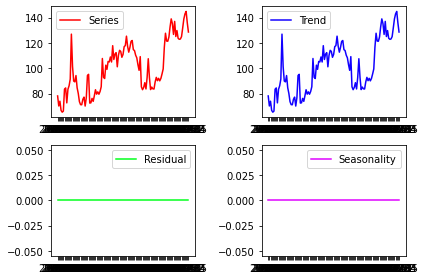

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition=seasonal_decompose(tseries, model='additive', freq=1)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.subplot(221)
plt.plot(tseries,color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual,color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal,color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

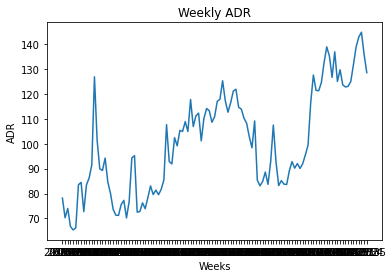

In [14]:
plt.plot(tseries)
plt.xlabel('Weeks')
plt.ylabel('ADR')
plt.title("Weekly ADR")
plt.show()

In [15]:
train_df=tseries[:100]
train_df

FullDate
201527     78.165879
201528     70.247336
201529     73.996534
201530     66.766446
201531     65.363578
             ...    
201716    121.461748
201717    121.316925
201718    124.661435
201719    132.639515
201720    138.961245
Name: ADR, Length: 100, dtype: float64

In [16]:
#Dickey-Fuller Test
result = ts.adfuller(train_df, 1)
result

(-2.087885740904639,
 0.24941362418987445,
 0,
 99,
 {'1%': -3.498198082189098,
  '5%': -2.891208211860468,
  '10%': -2.5825959973472097},
 704.6562516557327)

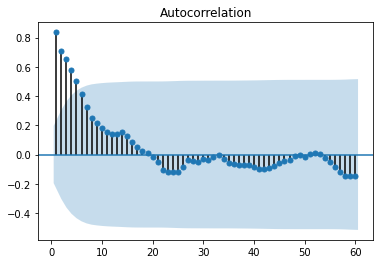

In [17]:
plot_acf(train_df, lags=60, zero=False);

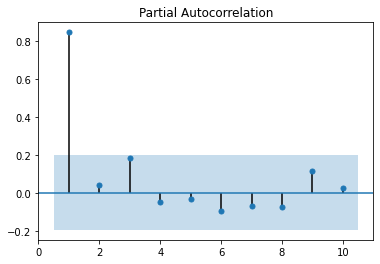

In [18]:
plot_pacf(train_df, lags=10, zero=False);

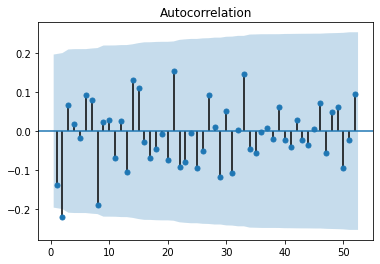

In [19]:
plot_acf(np.diff(train_df, 1), lags=52, zero=False);

In [20]:
test_df=tseries[100:115]
test_df

FullDate
201721    135.290186
201722    126.705491
201723    136.967315
201724    125.043687
201725    129.754353
201726    123.697777
201727    122.844838
201728    123.086751
201729    124.981143
201730    131.794585
201731    138.898408
201732    142.909221
201733    144.839923
201734    135.892708
201735    128.586952
Name: ADR, dtype: float64

In [21]:
window_size = 7

numbers_series = pd.Series(train_df)
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
ts7 = moving_averages_list[window_size - 1:]
ts7=np.array(ts7)
print(ts7)

[ 72.03285808  72.9338302   73.28200574  74.63266735  77.40941282
  81.13646404  89.81266064  92.37171262  93.14842817  95.51716779
  97.05935069  96.83636498  95.21555874  87.60632231  83.30345336
  80.63108747  78.66740672  76.23904681  74.17252804  73.70202548
  76.65109564  80.06845825  80.25784577  79.86054202  79.71492474
  80.24669662  80.46045097  78.85305274  76.62126978  77.88379994
  78.85183637  79.63330286  81.28373063  85.48364466  86.88547308
  88.64644659  91.65853677  94.46464269  97.84738606 100.63420342
 100.80684804 102.53164592 106.23202862 106.87143657 108.58984657
 109.5809166  109.03733527 109.22412158 110.54458027 109.89762492
 110.14468509 110.10050194 110.77887484 113.17143356 115.33029329
 115.77664471 115.6918513  116.8013492  118.2725721  118.96710446
 118.50729119 116.88320369 115.88365555 115.24659797 113.30080462
 110.0424092  108.22213142 104.03609116  99.62647823  95.98757533
  93.18536448  90.45323262  89.65499633  89.4186507   90.47250153
  90.48341

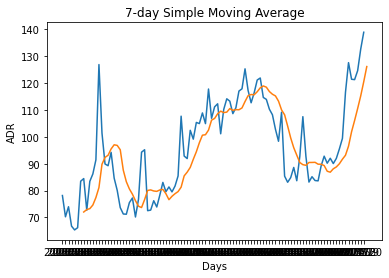

In [22]:
n1=math.nan
n7=np.array([n1,n1,n1,n1,n1,n1,n1])
ts7=np.concatenate([n7,ts7])
plt.plot(train_df)
plt.plot(ts7)
plt.xlabel('Days')
plt.ylabel('ADR')
plt.title("7-day Simple Moving Average")
plt.show()

In [23]:
Arima_model=pm.auto_arima(train_df, start_p=0, start_q=0, max_p=10, max_q=10, start_P=0, start_Q=0, max_P=10, max_Q=10, m=52, stepwise=True, seasonal=True, information_criterion='aic', trace=True, d=1, D=1, error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=361.928, Time=0.26 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=inf, Time=20.78 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=19.28 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=inf, Time=15.15 sec
 ARIMA(0,1,0)(0,1,1)[52]             : AIC=inf, Time=8.86 sec
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=365.921, Time=17.08 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=361.879, Time=0.52 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=15.91 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=28.48 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=360.608, Time=1.14 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=inf, Time=25.68 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=21.72 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=31.33 sec
 ARIMA(3,1,0)(0,1,0)[52]             : AIC=361.472, Time=0.99 sec
 ARIMA(2,1,1)(0,1,0)[52]             : AIC=360.213, Time=1.4

In [24]:
predictions=pd.DataFrame(Arima_model.predict(n_periods=15), index=test_df)
predictions=np.array(predictions)

In [25]:
predictions=predictions.reshape(15,-1)
predictions

array([[145.77521076],
       [131.41774191],
       [135.67741722],
       [136.80626411],
       [125.64588234],
       [134.71616934],
       [138.67323697],
       [137.7815602 ],
       [133.14716308],
       [135.36813519],
       [141.55487442],
       [142.39379337],
       [149.82818741],
       [141.79769691],
       [137.18800636]])

In [26]:
len(predictions)

15

In [27]:
predictions

array([[145.77521076],
       [131.41774191],
       [135.67741722],
       [136.80626411],
       [125.64588234],
       [134.71616934],
       [138.67323697],
       [137.7815602 ],
       [133.14716308],
       [135.36813519],
       [141.55487442],
       [142.39379337],
       [149.82818741],
       [141.79769691],
       [137.18800636]])

In [28]:
len(predictions)

15

In [29]:
len(test_df)

15

In [30]:
mse = mean_squared_error(test_df, predictions)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 8.553478


In [31]:
np.mean(test_df)

131.41955578664096

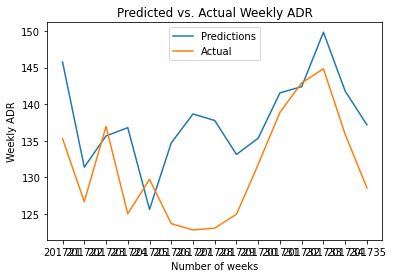

In [32]:
predictons, =plt.plot(predictions, label='Predictions')
actual, =plt.plot(test_df, label='Actual')
plt.xlabel('Number of weeks')
plt.ylabel('Weekly ADR')
plt.title("Predicted vs. Actual Weekly ADR")
plt.legend(loc = 'upper center')
plt.show()